# Getting Started with MLFinLab

This notebook provides a basic introduction to using MLFinLab for financial machine learning.

## Topics Covered:
- Basic imports and setup
- Loading financial data
- Creating bars (dollar, volume, tick)
- Basic feature engineering
- Visualization examples

## 1. Import Libraries

In [1]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# MLFinLab imports
# Uncomment and modify based on your specific needs:
# from mlfinlab.data_structures import standard_data_structures
# from mlfinlab.features import fracdiff
# from mlfinlab.labeling import triple_barrier
# from mlfinlab.util import multiprocess

# Financial data
import yfinance as yf

# Settings
plt.style.use('seaborn-v0_8')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Load Sample Data

In [6]:
# Let's first check the yfinance version and try to fix the issue
print("Checking yfinance version...")
print(f"yfinance version: {yf.__version__}")

# Try updating yfinance first
import subprocess
import sys

try:
    print("\nTrying to update yfinance...")
    result = subprocess.run([sys.executable, "-m", "pip", "install", "--upgrade", "yfinance"], 
                          capture_output=True, text=True, timeout=30)
    if result.returncode == 0:
        print("✅ yfinance updated successfully")
    else:
        print(f"⚠️ Update had issues: {result.stderr}")
except Exception as e:
    print(f"⚠️ Could not update yfinance: {e}")

# Try a different approach with explicit session
print("\n--- Trying with requests session ---")
import requests

# Create a session with headers
session = requests.Session()
session.headers.update({
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
})

try:
    ticker = 'AAPL'
    stock = yf.Ticker(ticker, session=session)
    
    print(f"Trying to download {ticker} with custom session...")
    data = stock.history(start='2020-01-01', end='2023-12-31')
    
    if not data.empty:
        print(f"✅ Success! Downloaded {len(data)} rows of data for {ticker}")
        print(f"Date range: {data.index.min().date()} to {data.index.max().date()}")
        successful_ticker = ticker
        
        # Display first few rows
        print(f"\nFirst few rows of {ticker}:")
        display(data.head())
        
    else:
        raise Exception("No data returned")
        
except Exception as e:
    print(f"❌ Session approach failed: {e}")
    
    # Fallback: Create sample data for demonstration
    print("\n--- Creating sample data for demonstration ---")
    print("Since yfinance is not working, creating synthetic stock data...")
    
    import numpy as np
    
    # Generate sample stock data
    np.random.seed(42)  # For reproducible results
    dates = pd.date_range(start='2020-01-01', end='2023-12-31', freq='D')
    dates = dates[dates.weekday < 5]  # Remove weekends
    
    # Generate realistic stock price data
    n_days = len(dates)
    price_start = 100
    returns = np.random.normal(0.001, 0.02, n_days)  # Daily returns with slight upward drift
    prices = [price_start]
    
    for i in range(1, n_days):
        new_price = prices[-1] * (1 + returns[i])
        prices.append(max(new_price, 0.01))  # Ensure price stays positive
    
    # Create volume data
    base_volume = 1000000
    volume = np.random.lognormal(np.log(base_volume), 0.5, n_days)
    
    # Create OHLC data
    highs = [p * (1 + abs(np.random.normal(0, 0.01))) for p in prices]
    lows = [p * (1 - abs(np.random.normal(0, 0.01))) for p in prices]
    opens = [prices[0]] + [prices[i-1] * (1 + np.random.normal(0, 0.005)) for i in range(1, n_days)]
    
    # Create DataFrame
    data = pd.DataFrame({
        'Open': opens,
        'High': highs,
        'Low': lows,
        'Close': prices,
        'Adj Close': prices,
        'Volume': volume.astype(int)
    }, index=dates)
    
    successful_ticker = 'SAMPLE_STOCK'
    
    print(f"✅ Created sample dataset with {len(data)} rows")
    print(f"Date range: {data.index.min().date()} to {data.index.max().date()}")
    print(f"Price range: ${data['Close'].min():.2f} to ${data['Close'].max():.2f}")
    
    print(f"\nFirst few rows of sample data:")
    display(data.head())

Checking yfinance version...
yfinance version: 0.2.28

Trying to update yfinance...
✅ yfinance updated successfully

--- Trying with requests session ---
Trying to download AAPL with custom session...
✅ yfinance updated successfully

--- Trying with requests session ---
Trying to download AAPL with custom session...


Failed to get ticker 'AAPL' reason: Expecting value: line 1 column 1 (char 0)
AAPL: No timezone found, symbol may be delisted
AAPL: No timezone found, symbol may be delisted


❌ Session approach failed: No data returned

--- Creating sample data for demonstration ---
Since yfinance is not working, creating synthetic stock data...
✅ Created sample dataset with 1043 rows
Date range: 2020-01-01 to 2023-12-29
Price range: $81.29 to $445.22

First few rows of sample data:


,Open,High,Low,Close,Adj Close,Volume
2020-01-01,100.000000,100.508140,99.588507,100.000000,100.000000,980929
2020-01-02,99.757913,99.970991,99.734395,99.823471,99.823471,917306
2020-01-03,99.341201,101.675147,101.178358,101.216385,101.216385,1555551
2020-01-06,101.127629,105.917100,102.593327,104.400713,104.400713,1385639
2020-01-07,104.657281,104.356066,102.461220,104.016198,104.016198,454664


## 3. Basic Data Exploration

In [7]:
# Basic statistics
print("Data Info:")
print(data.info())
print("\nBasic Statistics:")
data.describe()

Data Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1043 entries, 2020-01-01 to 2023-12-29
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1043 non-null   float64
 1   High       1043 non-null   float64
 2   Low        1043 non-null   float64
 3   Close      1043 non-null   float64
 4   Adj Close  1043 non-null   float64
 5   Volume     1043 non-null   int32  
dtypes: float64(5), int32(1)
memory usage: 53.0 KB
None

Basic Statistics:


,Open,High,Low,Close,Adj Close,Volume
count,1043.000000,1043.000000,1043.000000,1043.000000,1043.000000,1.043000e+03
mean,167.655968,169.340372,166.669560,168.006299,168.006299,1.156526e+06
std,80.155201,81.230318,80.049264,80.571023,80.571023,6.090398e+05
min,80.732509,82.298013,79.824728,81.290734,81.290734,2.209630e+05
25%,118.140393,118.456035,117.126872,117.842470,117.842470,7.337220e+05
50%,148.684959,150.042452,147.695352,148.922880,148.922880,1.014190e+06
75%,169.582980,170.852027,168.774718,169.563706,169.563706,1.424870e+06
max,439.083988,447.367512,444.509114,445.224283,445.224283,4.935992e+06


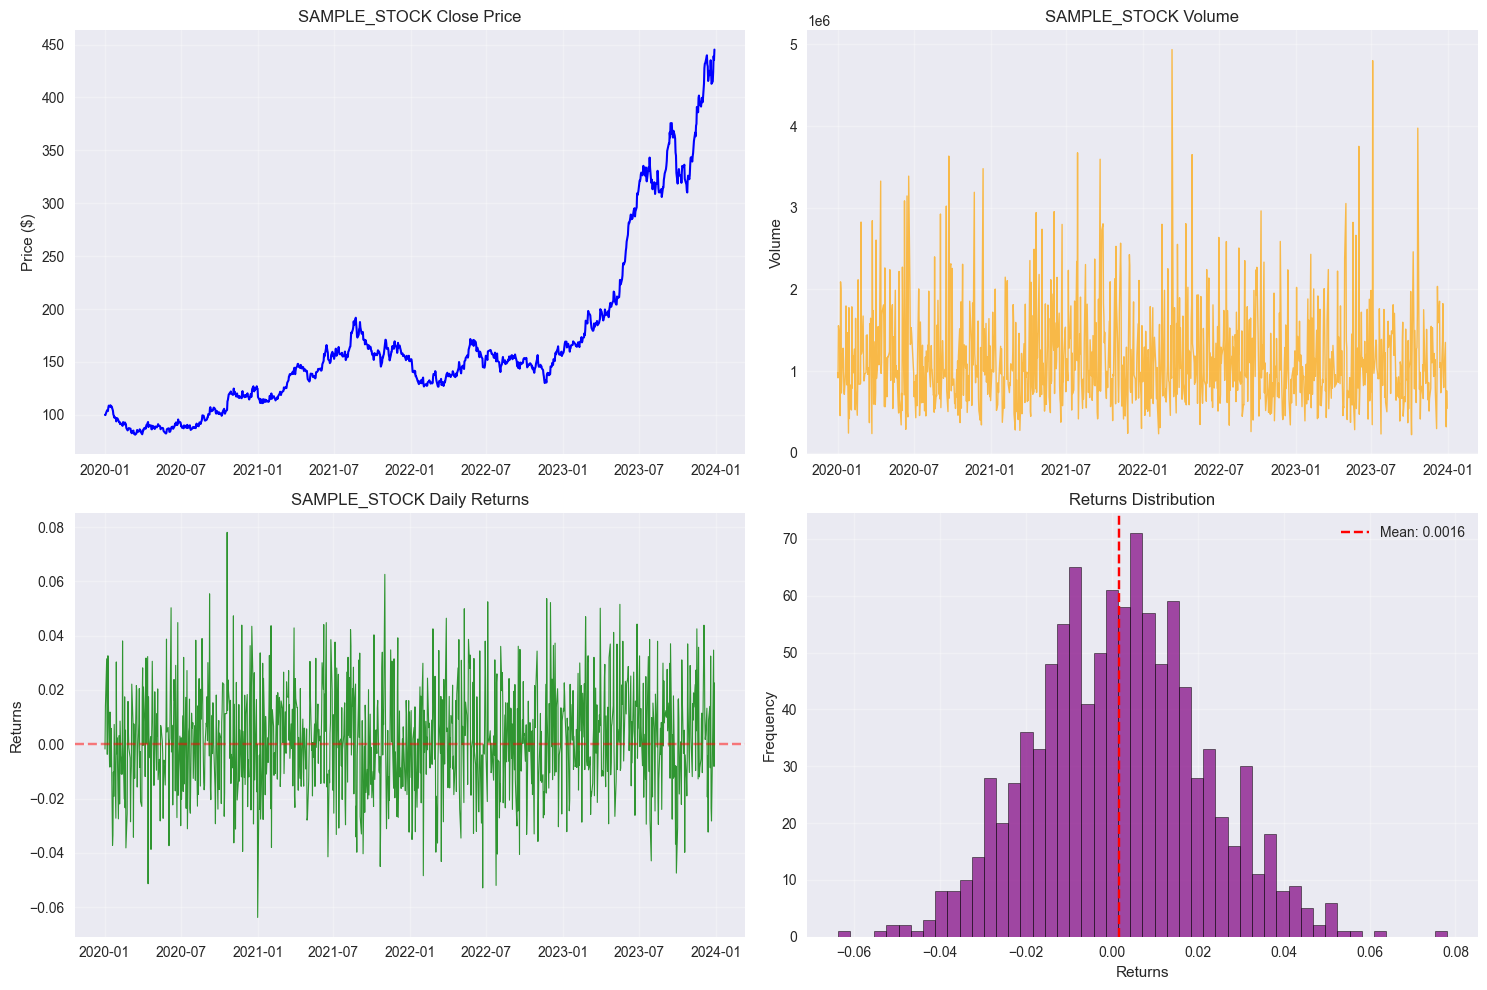


📊 SAMPLE_STOCK Statistics:
Total trading days: 1043
Date range: 2020-01-01 to 2023-12-29
Price range: $81.29 - $445.22
Average daily volume: 1,156,526
Daily return statistics:
  Mean: 0.0016 (40.96% annualized)
  Std Dev: 0.0196 (31.10% annualized)
  Min: -0.0638
  Max: 0.0781


In [8]:
# Visualize price data
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Use the ticker name from our successful download
ticker_name = successful_ticker if 'successful_ticker' in locals() else 'SAMPLE_STOCK'

# Price chart
axes[0, 0].plot(data.index, data['Close'], linewidth=1.5, color='blue')
axes[0, 0].set_title(f'{ticker_name} Close Price')
axes[0, 0].set_ylabel('Price ($)')
axes[0, 0].grid(True, alpha=0.3)

# Volume chart
axes[0, 1].plot(data.index, data['Volume'], linewidth=1, color='orange', alpha=0.7)
axes[0, 1].set_title(f'{ticker_name} Volume')
axes[0, 1].set_ylabel('Volume')
axes[0, 1].grid(True, alpha=0.3)

# Returns
returns = data['Close'].pct_change().dropna()
axes[1, 0].plot(data.index[1:], returns, linewidth=0.8, color='green', alpha=0.8)
axes[1, 0].set_title(f'{ticker_name} Daily Returns')
axes[1, 0].set_ylabel('Returns')
axes[1, 0].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[1, 0].grid(True, alpha=0.3)

# Returns histogram
axes[1, 1].hist(returns, bins=50, alpha=0.7, color='purple', edgecolor='black', linewidth=0.5)
axes[1, 1].set_title('Returns Distribution')
axes[1, 1].set_xlabel('Returns')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].axvline(x=returns.mean(), color='red', linestyle='--', 
                   label=f'Mean: {returns.mean():.4f}')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print some basic statistics
print(f"\n📊 {ticker_name} Statistics:")
print(f"Total trading days: {len(data)}")
print(f"Date range: {data.index.min().date()} to {data.index.max().date()}")
print(f"Price range: ${data['Close'].min():.2f} - ${data['Close'].max():.2f}")
print(f"Average daily volume: {data['Volume'].mean():,.0f}")
print(f"Daily return statistics:")
print(f"  Mean: {returns.mean():.4f} ({returns.mean()*252:.2%} annualized)")
print(f"  Std Dev: {returns.std():.4f} ({returns.std()*np.sqrt(252):.2%} annualized)")
print(f"  Min: {returns.min():.4f}")
print(f"  Max: {returns.max():.4f}")

## 4. MLFinLab Examples

### Note: 
The following cells contain example code structure. Uncomment and modify based on your specific MLFinLab installation and data requirements.

In [ ]:
# Example: Creating Dollar Bars
# Uncomment when you have tick data and MLFinLab properly installed

# dollar_bars = standard_data_structures.get_dollar_bars(
#     file_path='path_to_your_tick_data.csv',
#     threshold=1000000  # $1M threshold
# )

print("MLFinLab example code ready to use!")

In [ ]:
# Example: Fractional Differentiation
# Uncomment when MLFinLab is installed

# from mlfinlab.features.fracdiff import frac_diff_ffd
# 
# # Apply fractional differentiation to make series stationary
# close_prices = data['Close']
# diff_series = frac_diff_ffd(close_prices, d=0.4, thres=0.01)
# 
# plt.figure(figsize=(12, 6))
# plt.subplot(2, 1, 1)
# plt.plot(close_prices.index, close_prices)
# plt.title('Original Price Series')
# 
# plt.subplot(2, 1, 2)
# plt.plot(diff_series.index, diff_series)
# plt.title('Fractionally Differentiated Series')
# plt.tight_layout()
# plt.show()

print("Fractional differentiation example ready!")

## 5. Next Steps

1. Install MLFinLab: `pip install mlfinlab`
2. Get tick-level data for more advanced features
3. Explore specific MLFinLab modules:
   - Data structures (bars)
   - Feature engineering
   - Labeling methods
   - Portfolio optimization
   - Microstructural features

## Assignments and Projects

Use this space to document your course assignments and project progress.

In [ ]:
# Your code here
pass